## Enron POI Classification

### Project Overview

Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud.In this project, I will play detective, and put my machine learning skills to use by building an algorithm to identify Enron Employees who may have committed fraud based on the public Enron financial and email dataset.

### Python Preparation

In [2]:
import sys
import pickle
import numpy
import pandas
import sklearn
import matplotlib.pyplot as plt

%matplotlib inline

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier, dump_classifier_and_data

C:\Program Files\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Feature Selection

Ill be using all the extra features given by udacity.

All available features fall into three major types of features, namely financial features, email features and POI labels.

* financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']  (all units are in US dollars)

* email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

* POI label: [‘poi’] (boolean, represented as integer)


In [4]:
## Create features list
features_list = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 
                 'loan_advances', 'bonus', 'restricted_stock_deferred', 
                 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 
                 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees'] 

### Load the dictionary containing the dataset
enron_data = pickle.load(open("final_project_dataset.pkl", "r") )

## Load POI names file
f = open("poi_names.txt", "r")

# Print available information for Jeffrey Skilling
print enron_data["SKILLING JEFFREY K"]



{'salary': 1111258, 'to_messages': 3627, 'deferral_payments': 'NaN', 'total_payments': 8682716, 'exercised_stock_options': 19250000, 'bonus': 5600000, 'restricted_stock': 6843672, 'shared_receipt_with_poi': 2042, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 26093672, 'expenses': 29336, 'loan_advances': 'NaN', 'from_messages': 108, 'other': 22122, 'from_this_person_to_poi': 30, 'poi': True, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 1920000, 'email_address': 'jeff.skilling@enron.com', 'from_poi_to_this_person': 88}


# Outliers

I wanted to show few examples of outliers and then in later section we try to remove our outliers.

# Plot between bonus and salary

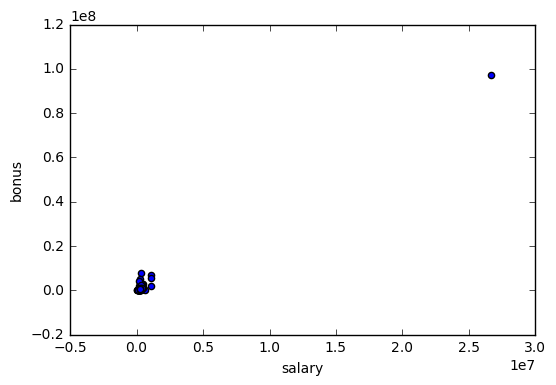

In [8]:
### read in data dictionary, convert to numpy array
data_dict = pickle.load( open("../final_project/final_project_dataset.pkl", "r") )
#data_dict.pop('TOTAL',0)
features = ["salary", "bonus"]
data = featureFormat(data_dict, features)





for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

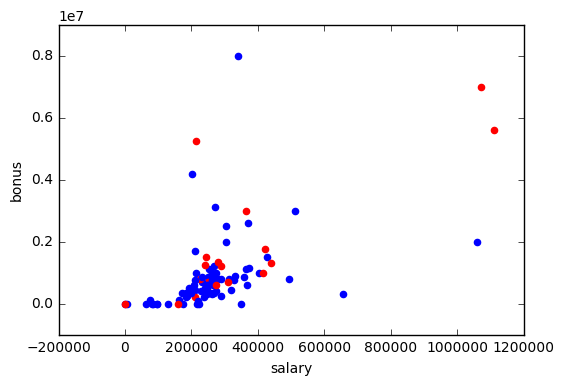

In [10]:
data_dict.pop('TOTAL',0)
features = ["salary", "bonus", "poi"]
data = featureFormat(data_dict, features)


for point in data:
    salary = point[0]
    bonus = point[1]
    if point[2] == 1:
        plt.scatter( salary, bonus, color = 'red' )
    else:
        plt.scatter( salary, bonus, color = 'blue' )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

# Plot between stockvalue and payments

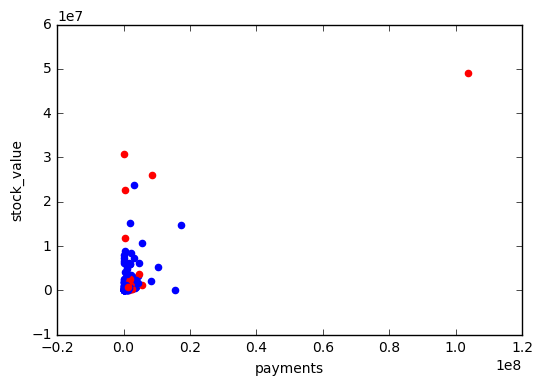

In [12]:

data_dict.pop('TOTAL',0)
features = ["total_payments", "total_stock_value", "poi"]
data = featureFormat(data_dict, features)


for point in data:
    payments = point[0]
    stock_value = point[1]
    if point[2] == 1:
        plt.scatter( payments, stock_value, color = 'red' )
    else:
        plt.scatter( payments, stock_value, color = 'blue' )

plt.xlabel("payments")
plt.ylabel("stock_value")
plt.show()

I want my classifier be adopted to 'NaN' variables, so i'm going to reformat dataset to numpy data frame. Ill be using pandas dataframe to handle this situation.

In [13]:
df = pandas.DataFrame.from_records(list(enron_data.values()))
persons = pandas.Series(list(enron_data.keys()))

print df.head()

     bonus deferral_payments deferred_income director_fees  \
0   600000               NaN             NaN           NaN   
1  1200000           1295738        -1386055           NaN   
2   350000               NaN         -400729           NaN   
3      NaN               NaN             NaN           NaN   
4  1500000               NaN        -3117011           NaN   

              email_address exercised_stock_options expenses from_messages  \
0      mark.metts@enron.com                     NaN    94299            29   
1                       NaN                 6680544    11200           NaN   
2  steven.elliott@enron.com                 4890344    78552           NaN   
3     bill.cordes@enron.com                  651850      NaN            12   
4    kevin.hannon@enron.com                 5538001    34039            32   

  from_poi_to_this_person from_this_person_to_poi        ...         \
0                      38                       1        ...          
1               

Looks very good. Let handle 'NaN' values in our nect section.

### Removing Outliers and Handling 'NaN' values

Let's define numeric columns list and look at variance without 'NaN'. See how many 'NaN' in each column and make decision about imputing this values or just removing this column from dataset.

In [14]:
# Convert to numpy nan
df.replace(to_replace='NaN', value=numpy.nan, inplace=True)

# Count number of NaN's for columns
print df.isnull().sum()

# DataFrame dimeansion
print df.shape

bonus                         64
deferral_payments            107
deferred_income               97
director_fees                129
email_address                 35
exercised_stock_options       44
expenses                      51
from_messages                 60
from_poi_to_this_person       60
from_this_person_to_poi       60
loan_advances                142
long_term_incentive           80
other                         53
poi                            0
restricted_stock              36
restricted_stock_deferred    128
salary                        51
shared_receipt_with_poi       60
to_messages                   60
total_payments                21
total_stock_value             20
dtype: int64
(146, 21)


If NaN counter more that 65, I'm going to remove this column, otherwise I do imputation. 

In [15]:
# Removing column from database if counter > 65

for column, series in df.iteritems():
    if series.isnull().sum() > 65:
        df.drop(column, axis=1, inplace=True)
       
# Drop email address column
if 'email_address' in list(df.columns.values):
    df.drop('email_address', axis=1, inplace=True)

        



df_imp = df.replace(to_replace=numpy.nan, value=0)
df_imp = df.fillna(0).copy(deep=True)
df_imp.columns = list(df.columns.values)
print df_imp.isnull().sum()
print df_imp.head()

df_imp.describe()

bonus                      0
exercised_stock_options    0
expenses                   0
from_messages              0
from_poi_to_this_person    0
from_this_person_to_poi    0
other                      0
poi                        0
restricted_stock           0
salary                     0
shared_receipt_with_poi    0
to_messages                0
total_payments             0
total_stock_value          0
dtype: int64
       bonus  exercised_stock_options  expenses  from_messages  \
0   600000.0                      0.0   94299.0           29.0   
1  1200000.0                6680544.0   11200.0            0.0   
2   350000.0                4890344.0   78552.0            0.0   
3        0.0                 651850.0       0.0           12.0   
4  1500000.0                5538001.0   34039.0           32.0   

   from_poi_to_this_person  from_this_person_to_poi      other    poi  \
0                     38.0                      1.0     1740.0  False   
1                      0.0            

,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,1.460000e+02,1.460000e+02,1.460000e+02,146.000000,146.000000,146.000000,1.460000e+02,1.460000e+02,1.460000e+02,146.000000,146.000000,1.460000e+02,1.460000e+02
mean,1.333474e+06,4.182736e+06,7.074827e+04,358.602740,38.226027,24.287671,5.854318e+05,1.749257e+06,3.658114e+05,692.986301,1221.589041,4.350622e+06,5.846018e+06
std,8.094029e+06,2.607040e+07,4.327163e+05,1441.259868,73.901124,79.278206,3.682345e+06,1.089995e+07,2.203575e+06,1072.969492,2226.770637,2.693448e+07,3.624681e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,-2.604490e+06,0.000000e+00,0.000000,0.000000,0.000000e+00,-4.409300e+04
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,8.115000e+03,0.000000e+00,0.000000,0.000000,9.394475e+04,2.288695e+05
50%,3.000000e+05,6.082935e+05,2.018200e+04,16.500000,2.500000,0.000000,9.595000e+02,3.605280e+05,2.105960e+05,102.500000,289.000000,9.413595e+05,9.659550e+05
75%,8.000000e+05,1.714221e+06,5.374075e+04,51.250000,40.750000,13.750000,1.506065e+05,8.145280e+05,2.708505e+05,893.500000,1585.750000,1.968287e+06,2.319991e+06
max,9.734362e+07,3.117640e+08,5.235198e+06,14368.000000,528.000000,609.000000,4.266759e+07,1.303223e+08,2.670423e+07,5521.000000,15149.000000,3.098866e+08,4.345095e+08


Just from summary we can explore big amount of outliers using max and .75 quantile. Actually i don't think that these are outliers or wrong data, it's just extreme values for some persons. Let's explore persons names at first.

In [16]:
print(enron_data.keys())

['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JOHN H', 'SHAPIRO RICHARD S', 'SHERRIFF JOHN R', 'SHELBY 

Generally all this string are names of persons from Enron data. But I've observed "TOTAL" and "THE TRAVEL AGENCY IN THE PARK", which aren't names. This observations should be deleted.

In [17]:
total_index = enron_data.keys().index("TOTAL")
print(total_index)
travel_index = enron_data.keys().index("THE TRAVEL AGENCY IN THE PARK")
print(travel_index)
df_subset = df_imp.drop(df_imp.index[[total_index,travel_index]])
df_subset.describe()


104
101


,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,1.440000e+02,1.440000e+02,144.000000,144.000000,144.000000,144.000000,1.440000e+02,1.440000e+02,1.440000e+02,144.000000,144.000000,1.440000e+02,1.440000e+02
mean,6.759974e+05,2.075802e+06,35375.340278,363.583333,38.756944,24.625000,2.947455e+05,8.685363e+05,1.854460e+05,702.611111,1238.555556,2.256543e+06,2.909786e+06
std,1.233155e+06,4.795513e+06,45309.303038,1450.675239,74.276769,79.778266,1.131325e+06,2.016572e+06,1.970421e+05,1077.290736,2237.564816,8.847189e+06,6.189018e+06
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-2.604490e+06,0.000000e+00,0.000000,0.000000,0.000000e+00,-4.409300e+04
25%,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.434500e+04,0.000000e+00,0.000000,0.000000,9.019275e+04,2.443265e+05
50%,3.000000e+05,6.082935e+05,20182.000000,17.500000,4.000000,0.000000,9.190000e+02,3.605280e+05,2.105960e+05,114.000000,347.500000,9.413595e+05,9.659550e+05
75%,8.000000e+05,1.683580e+06,53328.250000,53.000000,41.250000,14.000000,1.485770e+05,7.374560e+05,2.696675e+05,933.750000,1623.000000,1.945668e+06,2.295176e+06
max,8.000000e+06,3.434838e+07,228763.000000,14368.000000,528.000000,609.000000,1.035973e+07,1.476169e+07,1.111258e+06,5521.000000,15149.000000,1.035598e+08,4.911008e+07


After this feature engineering let's explore what values do we have and data dimension.

In [18]:
print "Values:", list(df_subset.columns.values)

print "Shape: ", df_subset.shape

print "Number of POI in DataSet: ", (df_subset['poi'] == 1).sum()
print "Number of non-POI in Dataset: ", (df_subset['poi'] == 0).sum()

Values: ['bonus', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'other', 'poi', 'restricted_stock', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']
Shape:  (144, 14)
Number of POI in DataSet:  18
Number of non-POI in Dataset:  126


### Creating new Features

In my opinion very useful feature is the ratio between messages connected with poi and all messages. I'm going to name this variable 'poi_ratio'. This variable store ratio in percentages. 
Also will be added next features:

- the fraction of all emails to a person that were sent from a person of interest
- the fraction of all emails that a person sent that were addressed to persons of interest

The hypothesis behind these features was that there might be stronger email connections between POIs than between POIs and non-POIs, and a scatterplot of these two features suggests that there might be some truth to that hypothesis.

Additionally i want to scale 'salary' to range [0,100].


In [19]:
poi_ratio = (df_subset['from_poi_to_this_person'] + df_subset['from_this_person_to_poi']) / (df_subset['from_messages'] + df_subset['to_messages'])
fraction_to_poi = (df_subset['from_this_person_to_poi']) / (df_subset['from_messages'])
fraction_from_poi = (df_subset['from_poi_to_this_person']) / (df_subset['to_messages'])
scale = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 100), copy=True)

df_subset['poi_ratio'] = pandas.Series(poi_ratio) * 100
df_subset['fraction_to_poi'] = pandas.Series(fraction_to_poi) * 100
df_subset['fraction_from_poi'] = pandas.Series(fraction_from_poi) * 100
salary_scaled = scale.fit_transform(df_subset['salary'])
df_subset.describe()

C:\Program Files\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,poi_ratio,fraction_to_poi,fraction_from_poi
count,1.440000e+02,1.440000e+02,144.000000,144.000000,144.000000,144.000000,1.440000e+02,1.440000e+02,1.440000e+02,144.000000,144.000000,1.440000e+02,1.440000e+02,86.000000,86.000000,86.000000
mean,6.759974e+05,2.075802e+06,35375.340278,363.583333,38.756944,24.625000,2.947455e+05,8.685363e+05,1.854460e+05,702.611111,1238.555556,2.256543e+06,2.909786e+06,4.770893,18.405548,3.796298
std,1.233155e+06,4.795513e+06,45309.303038,1450.675239,74.276769,79.778266,1.131325e+06,2.016572e+06,1.970421e+05,1077.290736,2237.564816,8.847189e+06,6.189018e+06,4.645513,21.061035,4.054439
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-2.604490e+06,0.000000e+00,0.000000,0.000000,0.000000e+00,-4.409300e+04,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.434500e+04,0.000000e+00,0.000000,0.000000,9.019275e+04,2.443265e+05,NaN,NaN,NaN
50%,3.000000e+05,6.082935e+05,20182.000000,17.500000,4.000000,0.000000,9.190000e+02,3.605280e+05,2.105960e+05,114.000000,347.500000,9.413595e+05,9.659550e+05,NaN,NaN,NaN
75%,8.000000e+05,1.683580e+06,53328.250000,53.000000,41.250000,14.000000,1.485770e+05,7.374560e+05,2.696675e+05,933.750000,1623.000000,1.945668e+06,2.295176e+06,NaN,NaN,NaN
max,8.000000e+06,3.434838e+07,228763.000000,14368.000000,528.000000,609.000000,1.035973e+07,1.476169e+07,1.111258e+06,5521.000000,15149.000000,1.035598e+08,4.911008e+07,22.435175,100.000000,21.734104


### Training Classifier

Split the data at first on training and test data. We will use Stratified Shuffle Split due to small dataset

In [16]:
labels = df_subset['poi'].copy(deep=True).astype(int).as_matrix()
features = (df_subset.drop('poi', axis=1)).fillna(0).copy(deep=True).as_matrix()
shuffle = sklearn.cross_validation.StratifiedShuffleSplit(labels, 4, test_size=0.3, random_state=0)

print labels
print features

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1]
[[  6.00000000e+05   0.00000000e+00   9.42990000e+04 ...,   4.66507177e+00
    3.44827586e+00   4.70879802e+00]
 [  1.20000000e+06   6.68054400e+06   1.12000000e+04 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  3.50000000e+05   4.89034400e+06   7.85520000e+04 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  6.00000000e+05   3.18125000e+06   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  8.00000000e+05   7.65920000e+05   9.62680000e+04 ...,   2.24351747e+01
    5.00000000e+01   2.17341040e+01]
 [  6.00000000e+05   3.84728000e+05   1.25978000e+05 ...,   6.52418448e+00
    3.75000000e+01   5.95647194e+00]]


Let's try four different initial models, and then start tune parameters of few models.

#### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=10)
scores = sklearn.cross_validation.cross_val_score(rf_clf, features, labels)

print scores

[ 0.85416667  0.89583333  0.85416667]


#### AdaBoost

In [18]:
from sklearn.ensemble import AdaBoostClassifier

ab_clf = AdaBoostClassifier(n_estimators=100)
scores = sklearn.cross_validation.cross_val_score(ab_clf, features, labels)
print scores 

[ 0.85416667  0.875       0.875     ]


#### Extremely Randomized Tree

In [20]:
from sklearn.ensemble import ExtraTreesClassifier

erf_clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
scores = sklearn.cross_validation.cross_val_score(erf_clf, features, labels)
print scores

[ 0.85416667  0.91666667  0.8125    ]


#### Gaussian Naive Bayes

In [21]:
from sklearn.naive_bayes import GaussianNB

gnb_clf = GaussianNB()
scores = sklearn.cross_validation.cross_val_score(gnb_clf, features, labels)
print scores

[ 0.85416667  0.89583333  0.77083333]


### Tunning Choosen Classifiers

Choosen Algorithms:

- Random Forest
- AdaBoost

Why not SVM? 

It's damn slow for tuning, computational time effiency is better.

Why not NB? 

It's too simple and time consuming.



#### Tuning Random Forest

Let's investigate main parameters of random forest:

- min_samples_split
- n_estimators
- min_samples_leaf
- criterion

In [22]:
from sklearn import grid_search

cv = sklearn.cross_validation.StratifiedShuffleSplit(labels, n_iter=10)

def scoring(estimator, features_test, labels_test):
     labels_pred = estimator.predict(features_test)
     p = sklearn.metrics.precision_score(labels_test, labels_pred, average='micro')
     r = sklearn.metrics.recall_score(labels_test, labels_pred, average='micro')
     if p > 0.3 and r > 0.3:
            return sklearn.metrics.f1_score(labels_test, labels_pred, average='macro')
     return 0
                                     
parameters = {'max_depth': [2,3,4,5,6],'min_samples_split':[2,3,4,5], 'n_estimators':[10,20,50], 'min_samples_leaf':[1,2,3,4], 'criterion':('gini', 'entropy')}
rf_clf = RandomForestClassifier()
rfclf = grid_search.GridSearchCV(rf_clf, parameters, scoring = scoring, cv = cv)
rfclf.fit(features, labels)

print rfclf.best_estimator_
print rfclf.best_score_

C:\Program Files\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
0.661344322344


#### Tuning AdaBoost

Let's investigate main parameters of adaboost:

- n_estimators
- learning_rate
- algorithm

In [23]:
from sklearn import grid_search
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
parameters = {'n_estimators' : [5, 10, 30, 40, 50, 100,150], 'learning_rate' : [0.1, 0.5, 1, 1.5, 2, 2.5], 'algorithm' : ('SAMME', 'SAMME.R')}
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=8))
adaclf = grid_search.GridSearchCV(ada_clf, parameters, scoring = scoring, cv = cv)
adaclf.fit(features, labels)

print adaclf.best_estimator_
print adaclf.best_score_

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=40, random_state=None)
0.725713675214


### Testing Classifier

#### Testing Random Forest best estimator

In [24]:
rf_best_clf = rfclf.best_estimator_
list_cols = list(df_subset.columns.values)
list_cols.remove('poi')
list_cols.insert(0, 'poi')
data = df_subset[list_cols].fillna(0).to_dict(orient='records')
enron_data_sub = {}
counter = 0
for item in data:
    enron_data_sub[counter] = item
    counter += 1
    
test_classifier(rf_best_clf, enron_data_sub, list_cols)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.85527	Precision: 0.37941	Recall: 0.13450	F1: 0.19860	F2: 0.15444
	Total predictions: 15000	True positives:  269	False positives:  440	False negatives: 1731	True negatives: 12560



#### Testing AdaBoost best estimator

In [25]:
ada_best_clf = adaclf.best_estimator_
test_classifier(ada_best_clf, enron_data_sub, list_cols)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=40, random_state=None)
	Accuracy: 0.82053	Precision: 0.32543	Recall: 0.32250	F1: 0.32396	F2: 0.32308
	Total predictions: 15000	True positives:  645	False positives: 1337	False negatives: 1355	True negatives: 11663



### Dump successful classifier

In [34]:
dump_classifier_and_data(ada_best_clf, enron_data_sub, list_cols)

### List Of Resources

- http://scikit-learn.org/stable/index.html
- http://pandas.pydata.org
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
- https://en.wikipedia.org/wiki/AdaBoost
- https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm